Main goal of this notebook is to compare different machine learning algorithms when solving problem of malware detection using data from computer memory analysis.
Author: Miłosz Majchrowski

# Imports

In [ ]:
#import os
from google.colab import drive

import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1_l2

# Data load

Kaggle data source [link](https://www.kaggle.com/datasets/luccagodoy/obfuscated-malware-memory-2022-cic) and oryginal source from cic [link](https://www.unb.ca/cic/datasets/malmem-2022.html)

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_raw = pd.read_csv('/content/drive/MyDrive/content/Obfuscated-MalMem2022.csv')

# Data review

Some basic informations about data set

In [ ]:
data_raw.shape

(58596, 57)

In [ ]:
data_raw.head(5)

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,221,26,24,116,0,121,87,0,8,Benign
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign


In [ ]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58596 entries, 0 to 58595
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Category                                58596 non-null  object 
 1   pslist.nproc                            58596 non-null  int64  
 2   pslist.nppid                            58596 non-null  int64  
 3   pslist.avg_threads                      58596 non-null  float64
 4   pslist.nprocs64bit                      58596 non-null  int64  
 5   pslist.avg_handlers                     58596 non-null  float64
 6   dlllist.ndlls                           58596 non-null  int64  
 7   dlllist.avg_dlls_per_proc               58596 non-null  float64
 8   handles.nhandles                        58596 non-null  int64  
 9   handles.avg_handles_per_proc            58596 non-null  float64
 10  handles.nport                           58596 non-null  in

In [ ]:
data_raw.describe()

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nport,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
count,58596.000000,58596.000000,58596.000000,58596.0,58596.000000,58596.000000,58596.000000,5.859600e+04,58596.000000,58596.0,...,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.0,58596.000000,58596.000000,58596.000000,58596.000000
mean,41.394771,14.713837,11.341655,0.0,247.509819,1810.805447,43.707806,1.025858e+04,249.560958,0.0,...,391.347549,221.406581,25.996245,25.063417,116.879514,0.0,121.995546,86.905659,0.000853,7.999881
std,5.777249,2.656748,1.588231,0.0,111.857790,329.782639,5.742023,4.866864e+03,145.999866,0.0,...,4.529704,1.991087,0.170790,1.529628,1.550401,0.0,2.822858,3.134117,0.029199,0.010929
min,21.000000,8.000000,1.650000,0.0,34.962500,670.000000,7.333333,3.514000e+03,71.139241,0.0,...,94.000000,55.000000,6.000000,7.000000,26.000000,0.0,30.000000,50.000000,0.000000,7.000000
25%,40.000000,12.000000,9.972973,0.0,208.725000,1556.000000,38.833333,8.393000e+03,209.648228,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,121.000000,87.000000,0.000000,8.000000
50%,41.000000,15.000000,11.000000,0.0,243.963710,1735.000000,42.781524,9.287500e+03,247.208951,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,122.000000,87.000000,0.000000,8.000000
75%,43.000000,16.000000,12.861955,0.0,289.974322,2087.000000,49.605280,1.219300e+04,291.355050,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,123.000000,88.000000,0.000000,8.000000
max,240.000000,72.000000,16.818182,0.0,24845.951220,3443.000000,53.170732,1.047310e+06,33784.193550,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,129.000000,89.000000,1.000000,8.000000


In [ ]:
data_raw.isnull().sum()

Category                                  0
pslist.nproc                              0
pslist.nppid                              0
pslist.avg_threads                        0
pslist.nprocs64bit                        0
pslist.avg_handlers                       0
dlllist.ndlls                             0
dlllist.avg_dlls_per_proc                 0
handles.nhandles                          0
handles.avg_handles_per_proc              0
handles.nport                             0
handles.nfile                             0
handles.nevent                            0
handles.ndesktop                          0
handles.nkey                              0
handles.nthread                           0
handles.ndirectory                        0
handles.nsemaphore                        0
handles.ntimer                            0
handles.nsection                          0
handles.nmutant                           0
ldrmodules.not_in_load                    0
ldrmodules.not_in_init          

There are no missing values to remove

In [ ]:
data_raw.nunique()

Category                                  28346
pslist.nproc                                114
pslist.nppid                                 49
pslist.avg_threads                        27885
pslist.nprocs64bit                            1
pslist.avg_handlers                       36463
dlllist.ndlls                              1860
dlllist.avg_dlls_per_proc                 16319
handles.nhandles                           7674
handles.avg_handles_per_proc              36144
handles.nport                                 1
handles.nfile                              1149
handles.nevent                             3469
handles.ndesktop                             64
handles.nkey                               1100
handles.nthread                            1170
handles.ndirectory                          108
handles.nsemaphore                          638
handles.ntimer                              129
handles.nsection                            629
handles.nmutant                         


Seweral columns contains only one value and should be removed

In [ ]:
identical_cols=data_raw.columns[data_raw.nunique() == 1]
print(identical_cols)

Index(['pslist.nprocs64bit', 'handles.nport',
       'svcscan.interactive_process_services'],
      dtype='object')


In [ ]:
data_raw.drop(columns=identical_cols, inplace=True)

Duplicats check

In [ ]:
print("Number of Duplicates", data_raw.duplicated().sum())

Number of Duplicates 534


In [ ]:
data_raw.drop_duplicates(inplace=True)

Main class distribution

In [ ]:
data_raw['Class'].value_counts()

Class
Benign     29231
Malware    28831
Name: count, dtype: int64

Separation of new label calsses

In [ ]:
data_raw['Category'].value_counts()

Category
Benign                                                                                         29231
Spyware-Transponder-0d5c256a6f3cfafaf59e8fb10bb8227fd2cfec90945df53f241195867df36975-10.raw        2
Spyware-Transponder-0d5c256a6f3cfafaf59e8fb10bb8227fd2cfec90945df53f241195867df36975-2.raw         2
Spyware-Transponder-0d5c256a6f3cfafaf59e8fb10bb8227fd2cfec90945df53f241195867df36975-3.raw         2
Spyware-Transponder-0d5c256a6f3cfafaf59e8fb10bb8227fd2cfec90945df53f241195867df36975-4.raw         2
                                                                                               ...  
Spyware-CWS-0cf2cad8755f91deb98e8fedf34c90728e9ec04647f806bc47964f85f5ebc050-1.raw                 1
Spyware-CWS-0cea2a077840879b6dfd21200b41a9e03493c2b5a3be17141a49836a29b516c4-9.raw                 1
Spyware-CWS-0cea2a077840879b6dfd21200b41a9e03493c2b5a3be17141a49836a29b516c4-8.raw                 1
Spyware-CWS-0cea2a077840879b6dfd21200b41a9e03493c2b5a3be17141a49836a29b516c4-7.raw

In [ ]:
data_raw['Type']=data_raw['Category'].apply(lambda x:re.sub(r'^(\w+-\w+).*',r'\1',x))

In [ ]:
data_raw['Type'].value_counts()

Type
Benign                  29231
Spyware-Transponder      2410
Ransomware-Shade         2128
Spyware-180solutions     2000
Spyware-CWS              2000
Trojan-Scar              2000
Trojan-Refroso           2000
Ransomware-Ako           2000
Spyware-Gator            1995
Ransomware-Conti         1988
Trojan-Emotet            1967
Trojan-Zeus              1950
Ransomware-Maze          1754
Ransomware-Pysa          1659
Trojan-Reconyc           1570
Spyware-TIBS             1410
Name: count, dtype: int64

In [ ]:
data_raw['Category']=data_raw['Type'].apply(lambda x:re.sub(r'^(\w+)-\w+',r'\1',x))

In [ ]:
data_raw['Category'].value_counts()

Category
Benign        29231
Spyware        9815
Ransomware     9529
Trojan         9487
Name: count, dtype: int64

In [ ]:
labels_NOuniqe = [['Class', data_raw['Class'].nunique()], ['Category', data_raw['Category'].nunique()], ['Type', data_raw['Type'].nunique()]]

df_lab_unq = pd.DataFrame(labels_NOuniqe, columns=['Label column', 'Unique Values'])


New label columns Class, Category and Type

In [ ]:
df_lab_unq

,Label column,Unique Values
0,Class,2
1,Category,4
2,Type,16


Numeric columns

In [ ]:
pslist_columns = [col for col in data_raw.columns if 'pslist' in col]
print(pslist_columns)

['pslist.nproc', 'pslist.nppid', 'pslist.avg_threads', 'pslist.avg_handlers', 'psxview.not_in_pslist', 'psxview.not_in_pslist_false_avg']


In [ ]:
numeric_columns = data_raw.select_dtypes(include='number').columns.tolist()
numeric_columns_groups = set(name.split('.')[0] for name in numeric_columns)
group_counts = {}
for group in numeric_columns_groups:
    group_columns = [col for col in numeric_columns if col.startswith(group)]
    group_count = data_raw[group_columns].count().sum()
    group_counts[group] = group_count

for group, count in group_counts.items():
    print(f'{group}: {count}')

handles: 696744
malfind: 232248
dlllist: 116124
pslist: 232248
modules: 58062
callbacks: 174186
svcscan: 348372
ldrmodules: 348372
psxview: 812868


In [ ]:
numeric_columns_info = []
for col in numeric_columns:
    unique_count = data_raw[col].nunique()
    dtype = data_raw[col].dtype
    numeric_columns_info.append((col, dtype, unique_count))


df_numeric_info = pd.DataFrame(numeric_columns_info, columns=['Column', 'Type', 'Unique Values Count'])

In [ ]:
df_numeric_info[df_numeric_info['Column'].str.startswith('callbacks')]

,Column,Type,Unique Values Count
49,callbacks.ncallbacks,int64,13
50,callbacks.nanonymous,int64,2
51,callbacks.ngeneric,int64,2


In [ ]:
df_numeric_info[df_numeric_info['Column'].str.startswith('dlllist')]

,Column,Type,Unique Values Count
4,dlllist.ndlls,int64,1860
5,dlllist.avg_dlls_per_proc,float64,16319


In [ ]:
df_numeric_info[df_numeric_info['Column'].str.startswith('handles')]

,Column,Type,Unique Values Count
6,handles.nhandles,int64,7674
7,handles.avg_handles_per_proc,float64,36144
8,handles.nfile,int64,1149
9,handles.nevent,int64,3469
10,handles.ndesktop,int64,64
11,handles.nkey,int64,1100
12,handles.nthread,int64,1170
13,handles.ndirectory,int64,108
14,handles.nsemaphore,int64,638
15,handles.ntimer,int64,129


In [ ]:
df_numeric_info[df_numeric_info['Column'].str.startswith('ldrmodules')]

,Column,Type,Unique Values Count
18,ldrmodules.not_in_load,int64,151
19,ldrmodules.not_in_init,int64,185
20,ldrmodules.not_in_mem,int64,151
21,ldrmodules.not_in_load_avg,float64,18673
22,ldrmodules.not_in_init_avg,float64,18838
23,ldrmodules.not_in_mem_avg,float64,18673


In [ ]:
df_numeric_info[df_numeric_info['Column'].str.startswith('malfind')]

,Column,Type,Unique Values Count
24,malfind.ninjections,int64,120
25,malfind.commitCharge,int64,559
26,malfind.protection,int64,215
27,malfind.uniqueInjections,float64,5526


In [ ]:
df_numeric_info[df_numeric_info['Column'].str.startswith('modules')]

,Column,Type,Unique Values Count
42,modules.nmodules,int64,3


In [ ]:
df_numeric_info[df_numeric_info['Column'].str.startswith('pslist')]

,Column,Type,Unique Values Count
0,pslist.nproc,int64,114
1,pslist.nppid,int64,49
2,pslist.avg_threads,float64,27885
3,pslist.avg_handlers,float64,36463


In [ ]:
df_numeric_info[df_numeric_info['Column'].str.startswith('psxview')]

,Column,Type,Unique Values Count
28,psxview.not_in_pslist,int64,41
29,psxview.not_in_eprocess_pool,int64,2
30,psxview.not_in_ethread_pool,int64,84
31,psxview.not_in_pspcid_list,int64,43
32,psxview.not_in_csrss_handles,int64,84
33,psxview.not_in_session,int64,41
34,psxview.not_in_deskthrd,int64,87
35,psxview.not_in_pslist_false_avg,float64,9690
36,psxview.not_in_eprocess_pool_false_avg,float64,196
37,psxview.not_in_ethread_pool_false_avg,float64,10421


In [ ]:
df_numeric_info[df_numeric_info['Column'].str.startswith('svcscan')]

,Column,Type,Unique Values Count
43,svcscan.nservices,int64,31
44,svcscan.kernel_drivers,int64,20
45,svcscan.fs_drivers,int64,10
46,svcscan.process_services,int64,14
47,svcscan.shared_process_services,int64,23
48,svcscan.nactive,int64,35


In [ ]:
data_raw["Class"].count()

58062

In [ ]:
data_raw.shape

(58062, 55)

# Visualization

LAbels distribution Class, Category and Type

<ipython-input-36-2a470c752be9>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_raw["Class"], palette="tab10")


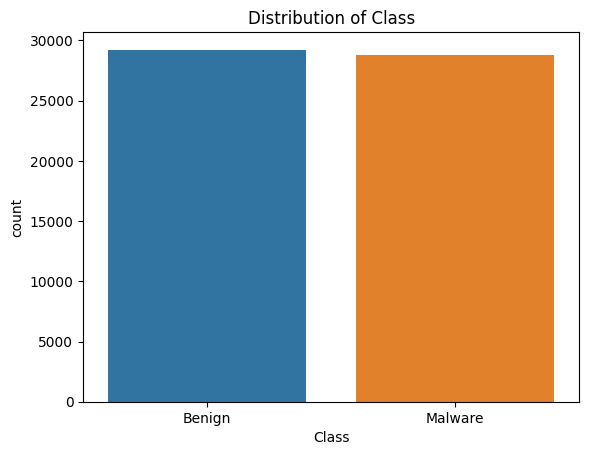

In [ ]:
sns.countplot(x=data_raw["Class"], palette="tab10")
plt.title("Distribution of Class")
plt.show()

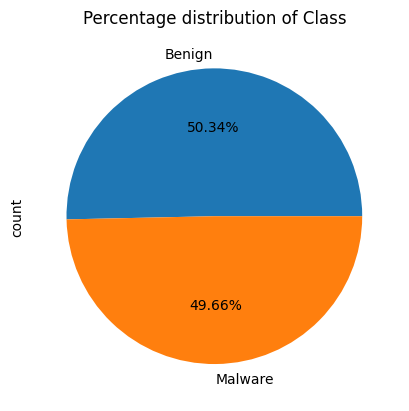

In [ ]:
data_raw["Class"].value_counts().plot(kind="pie", autopct="%.2f%%")
plt.title("Percentage distribution of Class")
plt.show()

<ipython-input-38-5121b083ff1e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_raw["Category"], palette="tab10")


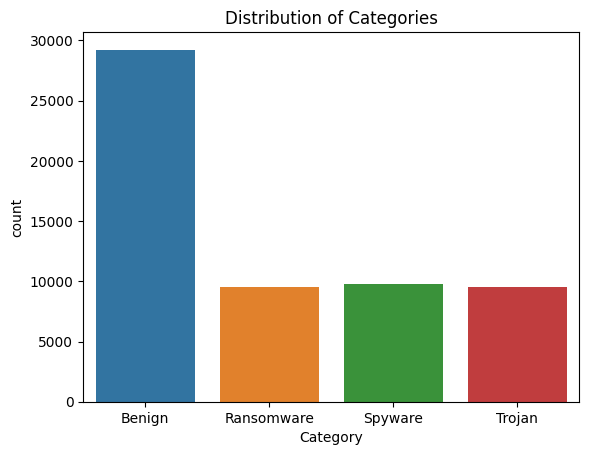

In [ ]:
sns.countplot(x=data_raw["Category"], palette="tab10")
plt.title("Distribution of Categories")
plt.show()

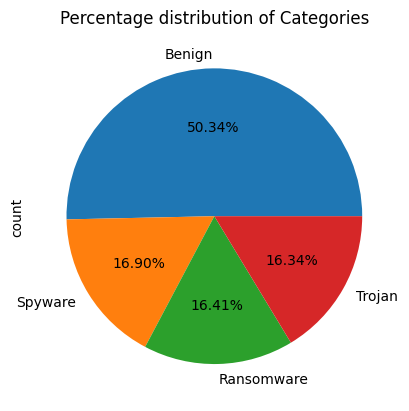

In [ ]:
data_raw["Category"].value_counts().plot(kind="pie", autopct="%.2f%%")
plt.title("Percentage distribution of Categories")
plt.show()

<ipython-input-40-f22128da135d>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_raw["Type"], palette="tab10")


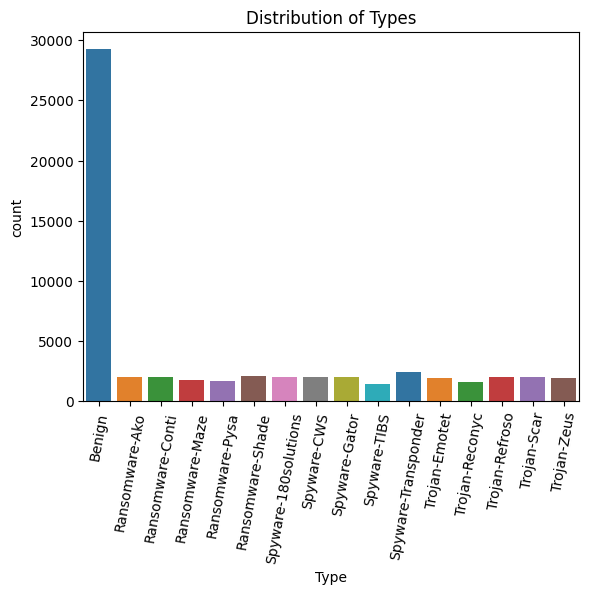

In [ ]:
sns.countplot(x=data_raw["Type"], palette="tab10")
plt.title("Distribution of Types")
plt.xticks(rotation=80)
plt.show()

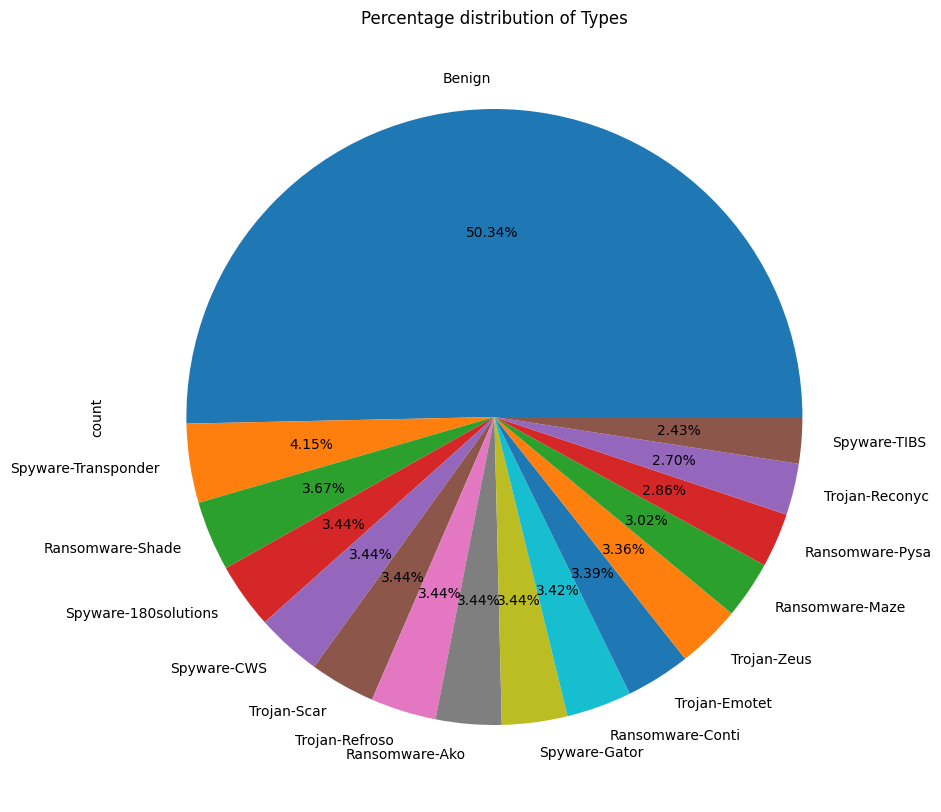

In [ ]:
plt.figure(figsize=(10, 10))
data_raw["Type"].value_counts().plot(kind="pie", autopct="%.2f%%")
plt.title("Percentage distribution of Types")
plt.show()

Percentage distribution of numeric features

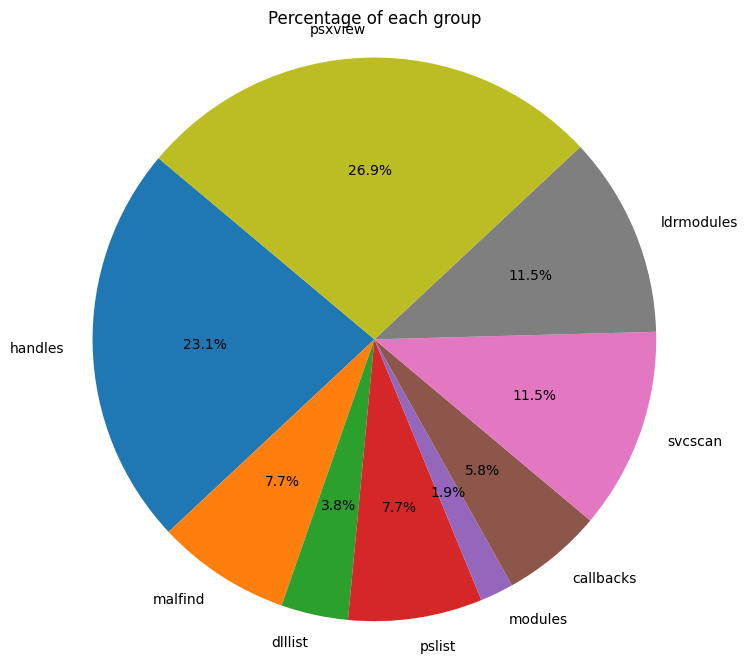

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(group_counts.values(), labels=group_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Percentage of each group')
plt.axis('equal')
plt.show()

correlation check


In [ ]:
print(data_raw.columns[data_raw.nunique() == 2])

Index(['psxview.not_in_eprocess_pool', 'callbacks.nanonymous',
       'callbacks.ngeneric', 'Class'],
      dtype='object')


In [ ]:
data_raw['psxview.not_in_eprocess_pool'].value_counts()

psxview.not_in_eprocess_pool
0    57940
1      122
Name: count, dtype: int64

In [ ]:
data_raw['callbacks.nanonymous'].value_counts()

callbacks.nanonymous
0    58012
1       50
Name: count, dtype: int64

In [ ]:
data_raw['callbacks.ngeneric'].value_counts()

callbacks.ngeneric
8    58055
7        7
Name: count, dtype: int64

In [ ]:
temp_df = data_raw[["Class", "psxview.not_in_eprocess_pool", "callbacks.nanonymous",
       "callbacks.ngeneric"]].copy()
temp_df["Class"] = temp_df["Class"].map({'Benign': 0, 'Malware': 1})

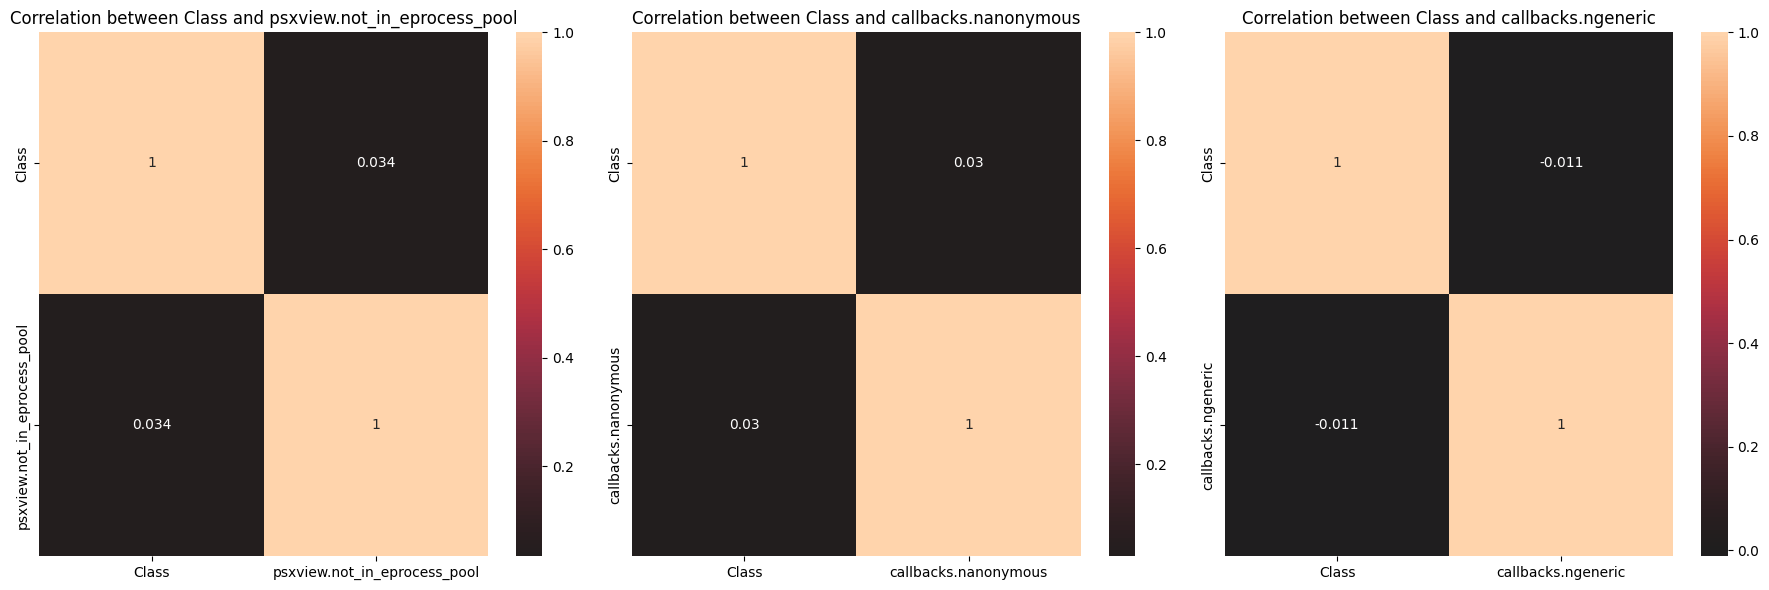

In [ ]:


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(temp_df[["Class", "psxview.not_in_eprocess_pool"]].corr(), annot=True, center=0.0, ax=axes[0])
axes[0].set_title('Correlation between Class and psxview.not_in_eprocess_pool')

sns.heatmap(temp_df[["Class", "callbacks.nanonymous"]].corr(), annot=True, center=0.0, ax=axes[1])
axes[1].set_title('Correlation between Class and callbacks.nanonymous')

sns.heatmap(temp_df[["Class", "callbacks.ngeneric"]].corr(), annot=True, center=0.0, ax=axes[2])
axes[2].set_title('Correlation between Class and callbacks.ngeneric')

plt.tight_layout()
plt.show()

# Feature extraction

Scaler

In [ ]:
labels = data_raw['Class'].unique()
data_raw['Class'] = data_raw['Class'].map({'Benign': 0, 'Malware': 1})
data_raw['Class']

X_data = data_raw.drop(columns=["Class", "Category", "Type"])
y_data = data_raw["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

**PCA**

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

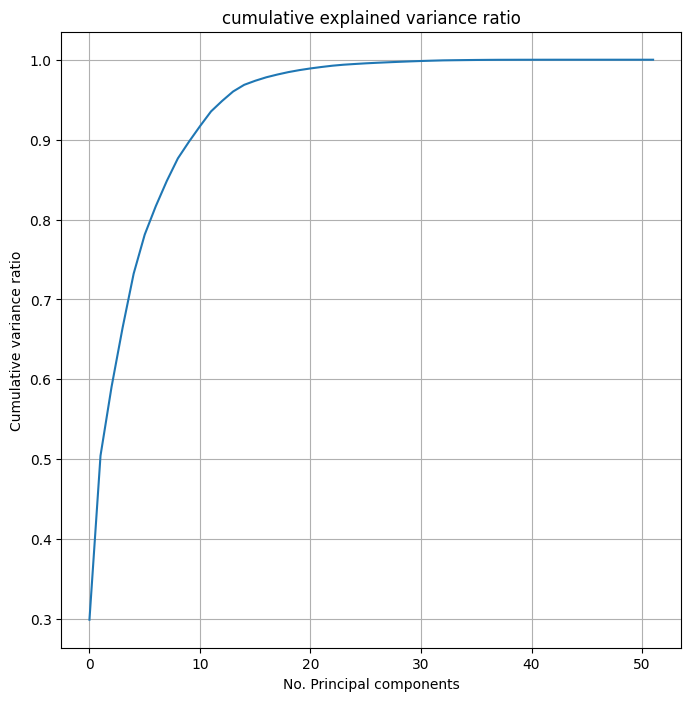

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(cumulative_variance_ratio)
plt.title("cumulative explained variance ratio")
plt.xlabel('No. Principal components')
plt.ylabel('Cumulative variance ratio')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(0.95)
X_pca = pca.fit_transform(X_scaled)


In [ ]:
X_pca.shape

(58062, 14)

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.2992114 , 0.20532268, 0.08612395, 0.0740518 , 0.06758696,
       0.04885194, 0.03550966, 0.03168342, 0.02818314, 0.02078047,
       0.01949954, 0.01851886, 0.0130553 , 0.01187193])

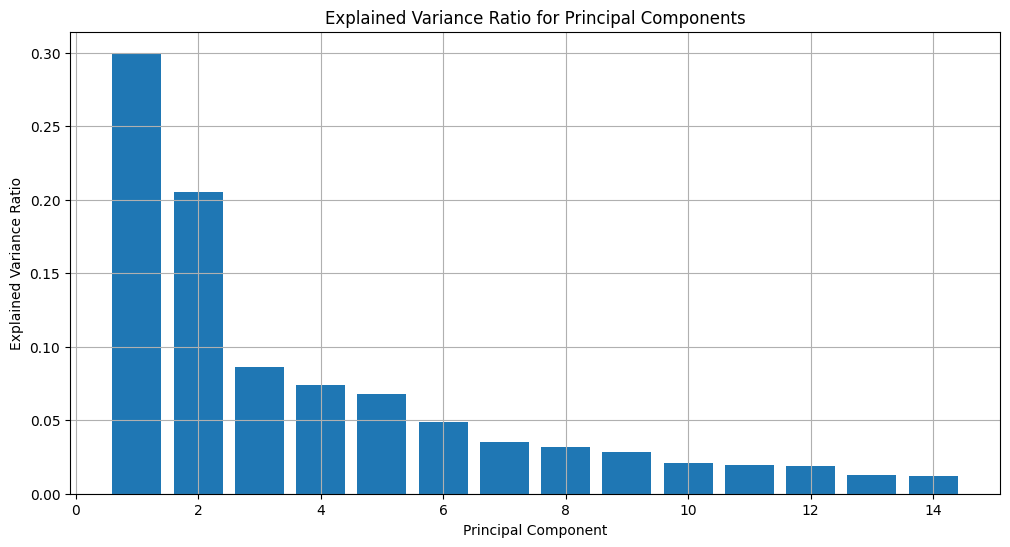

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.title('Explained Variance Ratio for Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Data split

In [ ]:
labels_category = data_raw['Category'].unique()
#data_raw['Category'] = data_raw['Category'].map({'Benign': 0, 'Ransomware': 1, 'Spyware': 2, 'Trojan': 3})
X_data = data_raw.drop(columns=["Class", "Category", "Type"])
y_data = data_raw["Category"]


In [ ]:
y_data

0            Benign
1            Benign
2            Benign
3            Benign
4            Benign
            ...    
58591    Ransomware
58592    Ransomware
58593    Ransomware
58594    Ransomware
58595    Ransomware
Name: Category, Length: 58062, dtype: object

In [ ]:
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(y_data)
y_data=to_categorical(y_data)

In [ ]:
y_data

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.15, random_state=11, shuffle=True, stratify=y_data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=11, shuffle=True, stratify=y_train)

In [ ]:
print("train size: ", X_train.shape, y_train.shape)
print("validation size: ",X_val.shape, y_val.shape)
print("test_size :", X_test.shape, y_test.shape)

train size:  (41949, 52) (41949, 4)
validation size:  (7403, 52) (7403, 4)
test_size : (8710, 52) (8710, 4)


In [ ]:
X_data=scaler.fit_transform(X_data)

In [ ]:
X_train_scal, X_test_scal, y_train_scal, y_test_scal = train_test_split(X_data, y_data, test_size=0.15, random_state=11, shuffle=True, stratify=y_data)
X_train_scal, X_val_scal, y_train_scal, y_val_scal = train_test_split(X_train_scal, y_train_scal, test_size=0.15, random_state=11, shuffle=True, stratify=y_train_scal)

In [ ]:
print("train size: ", X_train_scal.shape, y_train_scal.shape)
print("validation size: ",X_val_scal.shape, y_val_scal.shape)
print("test_size :", X_test_scal.shape, y_test_scal.shape)


train size:  (41949, 52) (41949, 4)
validation size:  (7403, 52) (7403, 4)
test_size : (8710, 52) (8710, 4)


In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_data, test_size=0.15, random_state=11, shuffle=True, stratify=y_data)
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_train_pca, y_train_pca, test_size=0.15, random_state=11, shuffle=True, stratify=y_train_pca)


In [ ]:
print("train size: ", X_train_pca.shape, y_train_pca.shape)
print("validation size: ",X_val_pca.shape, y_val_pca.shape)
print("test_size :", X_test_pca.shape, y_test_pca.shape)

train size:  (41949, 14) (41949, 4)
validation size:  (7403, 14) (7403, 4)
test_size : (8710, 14) (8710, 4)


In [ ]:
labels_category

array(['Benign', 'Ransomware', 'Spyware', 'Trojan'], dtype=object)


creating a dictionary label: weight containing weights of classes which can be used for improvement results of some algorithms

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weights_dict)


{0: 0.4965789099862683, 1: 1.5234238814642649, 2: 1.478743654822335, 3: 1.530091917128684}


# Decision tree


Function returning precision, recal, f1 on classes 0 and merged 1,2,3, accuracy and also confusion matrix

In [ ]:
def make_pred(model,X_test, y_test_met, cond=0):

  y_pred = model.predict(X_test)

  if cond != 0:
    y_pred = np.argmax(y_pred, axis=1)
    y_test_met = np.argmax(y_test_met, axis=1)
  accuracy = accuracy_score(y_test_met,y_pred)
  print("Accuracy for: ",model,": ", accuracy)

  cm = confusion_matrix(y_test_met, y_pred)
  sns.heatmap(cm,annot=True, fmt='g', cmap="Blues", xticklabels=labels_category, yticklabels=labels_category)
  plt.xlabel('Przewidziana etykieta')
  plt.ylabel('Prawdziwa etykieta')
  plt.title('Macierz pomyłek')
  plt.show()

  y_pred_ban = np.where((y_pred == 1) | (y_pred == 2) | (y_pred == 3), 1, y_pred)
  y_test_ban = np.where((y_test_met == 1) | (y_test_met == 2) | (y_test_met == 3), 1, y_test_met)

  precision = precision_score(y_test_ban, y_pred_ban)
  recall = recall_score(y_test_ban, y_pred_ban)
  f1 = f1_score(y_test_ban, y_pred_ban)
  print("precision: ",precision)
  print("recall: ",recall)
  print("f1: ",f1)

  l_category=['0 Benign', '1 Malware']
  cm = confusion_matrix(y_test_ban, y_pred_ban)
  sns.heatmap(cm,annot=True, fmt='g', cmap="Blues", xticklabels=l_category, yticklabels=l_category)
  plt.xlabel('Przewidziana etykieta')
  plt.ylabel('Prawdziwa etykieta')
  plt.title('Macierz pomyłek')
  plt.show()
  return accuracy, precision, recall, f1, y_pred

In [ ]:
columns = ['Model', 'Accuracy', 'Precision on Benign vs Malware', 'Recal on Benign vs Malware', 'F1 on Benign vs Malware']
models_dataframe = pd.DataFrame(columns=columns)

Accuracy for:  DecisionTreeClassifier() :  0.8404133180252583


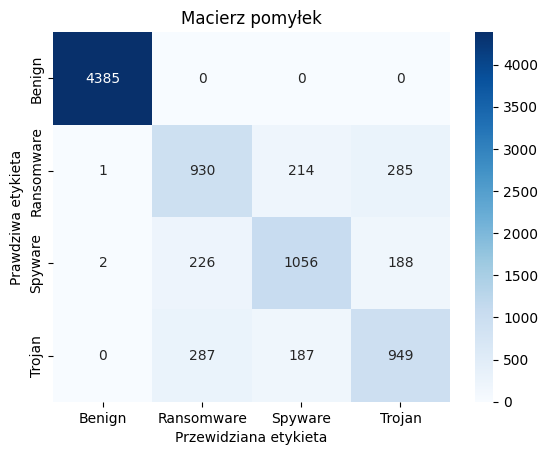

precision:  1.0
recall:  0.9993063583815028
f1:  0.999653058864346


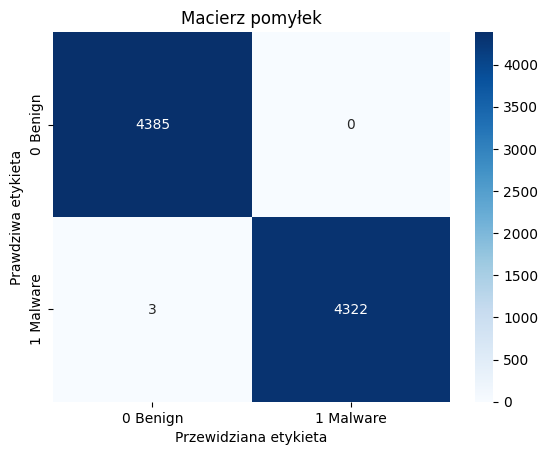

In [ ]:
model_dt=DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
accuracy_dt, precision_dt, recall_dt, f1_dt, preds_dt = make_pred(model_dt, X_test, y_test, 1)


In [ ]:
models_dataframe.loc[len(models_dataframe.index)] = ['Decision tree',accuracy_dt, precision_dt, recall_dt, f1_dt]

In [ ]:
print('głębokość drzewa ',model_dt.get_depth())
print('liczba liści ',model_dt.get_n_leaves())
print('liczba węzłów ',model_dt.tree_.node_count)

głębokość drzewa  41
liczba liści  4712
liczba węzłów  9423


In [ ]:
"""
model_dt=DecisionTreeClassifier()
param_grid = {
    'max_depth': [ 10, 50, 100],
    'min_samples_split': [2, 5, 20],
    'min_samples_leaf': [1, 5, 20]
}
grid_search = GridSearchCV(estimator=model_dt, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Najlepsze parametry:", grid_search.best_params_)
"""


'\nmodel_dt=DecisionTreeClassifier()\nparam_grid = {\n    \'max_depth\': [ 10, 50, 100],\n    \'min_samples_split\': [2, 5, 20],\n    \'min_samples_leaf\': [1, 5, 20]\n}\ngrid_search = GridSearchCV(estimator=model_dt, param_grid=param_grid, cv=5)\ngrid_search.fit(X_train, y_train)\nprint("Najlepsze parametry:", grid_search.best_params_)\n'

In [ ]:
#model_dt=DecisionTreeClassifier(**grid_search.best_params_)
#model_dt=DecisionTreeClassifier(max_depth=22,min_samples_leaf=1,min_samples_split=10)
#model_dt.fit(X_train, y_train)
#accuracy_dt, precision_dt, recall_dt, f1_dt, preds_dt = make_pred(model_dt, X_test, y_test, 1)
#models_dataframe.loc[len(models_dataframe.index)] = ['Decision tree',accuracy_dt, precision_dt, recall_dt, f1_dt]

In [ ]:
importances = model_dt.feature_importances_

feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

print(feature_importance_df)

                                   Feature  Importance
43                       svcscan.nservices    0.495899
11                            handles.nkey    0.039306
23               ldrmodules.not_in_mem_avg    0.037740
8                            handles.nfile    0.035739
14                      handles.nsemaphore    0.031674
5                dlllist.avg_dlls_per_proc    0.028613
9                           handles.nevent    0.023094
3                      pslist.avg_handlers    0.023061
12                         handles.nthread    0.022211
7             handles.avg_handles_per_proc    0.021050
16                        handles.nsection    0.020602
2                       pslist.avg_threads    0.020521
22              ldrmodules.not_in_init_avg    0.019511
6                         handles.nhandles    0.017165
18                  ldrmodules.not_in_load    0.017119
17                         handles.nmutant    0.017058
4                            dlllist.ndlls    0.014513
21        

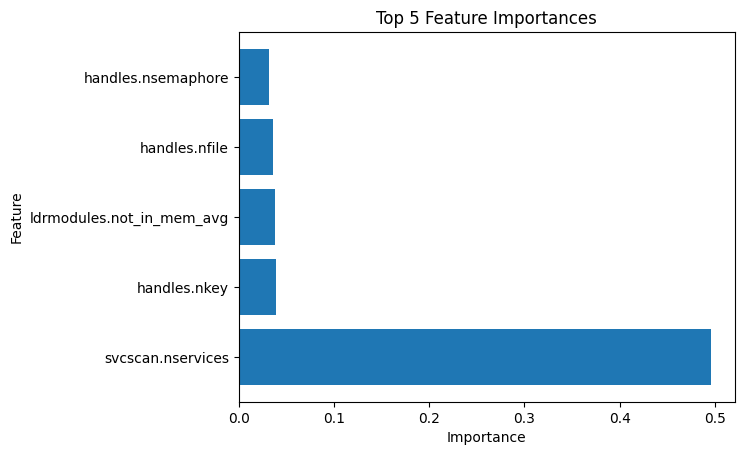

In [ ]:
plt.barh(feature_importance_df["Feature"][:5], feature_importance_df["Importance"][:5])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 5 Feature Importances")
plt.show()

In [ ]:
models_dataframe

,Model,Accuracy,Precision on Benign vs Malware,Recal on Benign vs Malware,F1 on Benign vs Malware
0,Decision tree,0.840413,1.0,0.999306,0.999653


# Ensemble models

Accuracy for:  BaggingClassifier(estimator=DecisionTreeClassifier()) :  0.8692307692307693


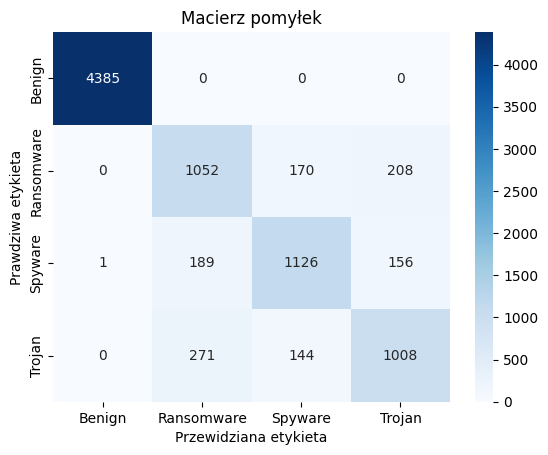

precision:  1.0
recall:  0.9997687861271676
f1:  0.9998843796970748


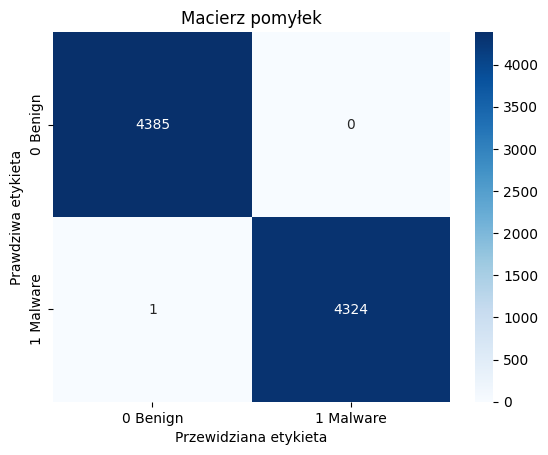

In [ ]:
model_bagging = BaggingClassifier(
    DecisionTreeClassifier(),
    bootstrap=True,
)
model_bagging.fit(X_train, np.argmax(y_train, axis=1))

accuracy_bagging, precision_bagging, recall_bagging, f1_bagging, preds_bagging = make_pred(model_bagging, X_test, np.argmax(y_test, axis=1))


In [ ]:
models_dataframe.loc[len(models_dataframe.index)] = ['Bagging',accuracy_bagging, precision_bagging, recall_bagging, f1_bagging]



In [ ]:
print("liczba estymatorów(drzew)",len(model_bagging.estimators_))

liczba estymatorów(drzew) 10


In [ ]:
mean_dp = np.mean([
    tree.get_depth() for tree in model_bagging.estimators_
], axis=0)
print("średnia głębokość drzew", mean_dp)

średnia głębokość drzew 34.9


In [ ]:
importances = np.mean([
    tree.feature_importances_ for tree in model_bagging.estimators_
], axis=0)

feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

print(feature_importance_df)

                                   Feature  Importance
43                       svcscan.nservices    0.496498
8                            handles.nfile    0.036238
11                            handles.nkey    0.033404
14                      handles.nsemaphore    0.029231
7             handles.avg_handles_per_proc    0.027016
23               ldrmodules.not_in_mem_avg    0.025211
9                           handles.nevent    0.025019
12                         handles.nthread    0.024962
2                       pslist.avg_threads    0.023919
21              ldrmodules.not_in_load_avg    0.023216
22              ldrmodules.not_in_init_avg    0.021820
5                dlllist.avg_dlls_per_proc    0.021783
16                        handles.nsection    0.019994
3                      pslist.avg_handlers    0.019282
17                         handles.nmutant    0.019051
6                         handles.nhandles    0.019031
20                   ldrmodules.not_in_mem    0.014165
4         

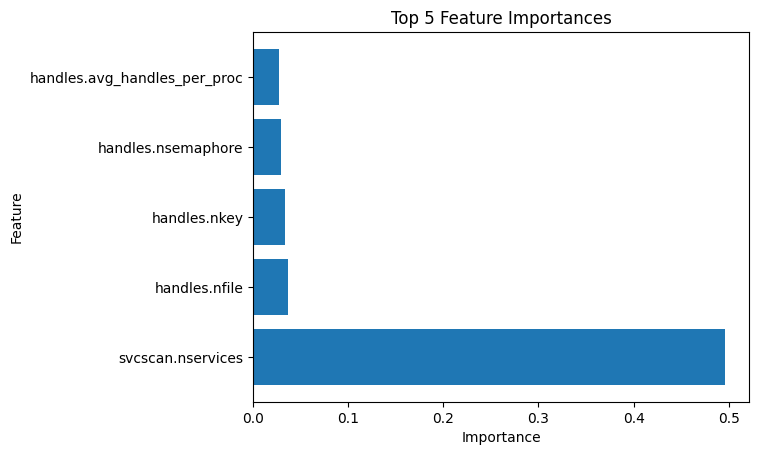

In [ ]:
plt.barh(feature_importance_df["Feature"][:5], feature_importance_df["Importance"][:5])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 5 Feature Importances")
plt.show()

In [ ]:
models_dataframe

,Model,Accuracy,Precision on Benign vs Malware,Recal on Benign vs Malware,F1 on Benign vs Malware
0,Decision tree,0.840413,1.0,0.999306,0.999653
1,Bagging,0.869231,1.0,0.999769,0.999884


Accuracy for:  RandomForestClassifier() :  0.8328358208955224


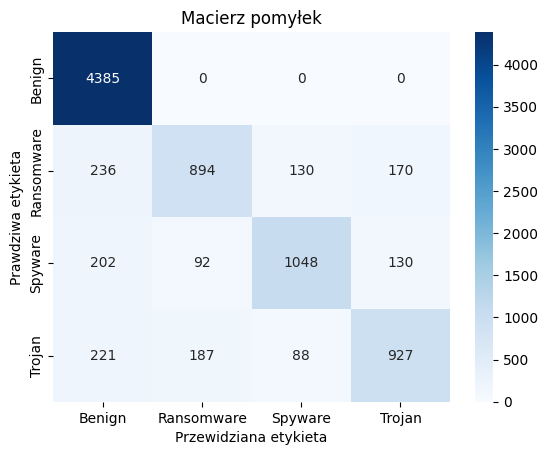

precision:  1.0
recall:  0.8476300578034682
f1:  0.9175322237517206


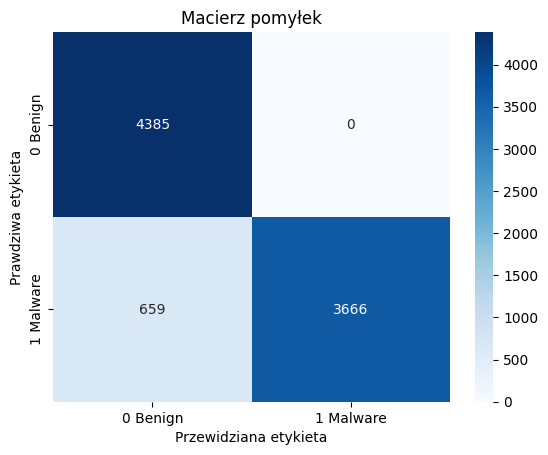

In [ ]:
model_rnd_forest = RandomForestClassifier()
model_rnd_forest.fit(X_train, y_train)
accuracy_rnd, precision_rnd, recall_rnd, f1_rnd, preds_rnd = make_pred(model_rnd_forest, X_test, y_test, 1)

Accuracy for:  RandomForestClassifier(class_weight={0: 0.4965789099862683,
                                     1: 1.5234238814642649,
                                     2: 1.478743654822335,
                                     3: 1.530091917128684}) :  0.8711825487944891


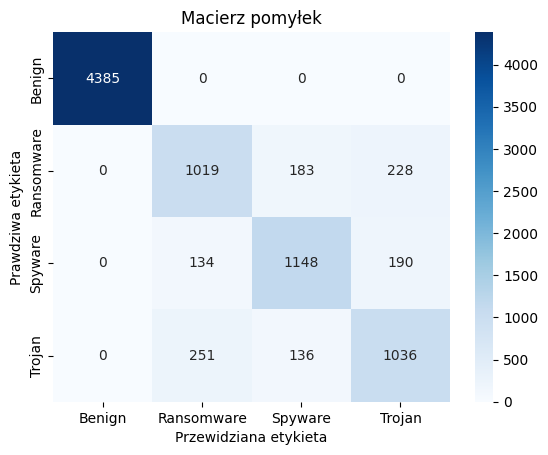

precision:  1.0
recall:  1.0
f1:  1.0


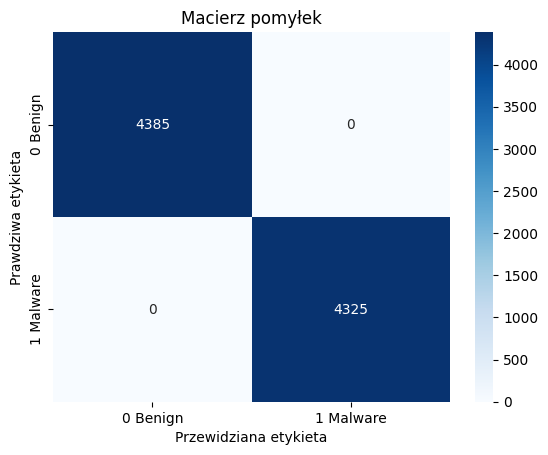

In [ ]:
model_rnd_forest = RandomForestClassifier(class_weight=class_weights_dict)
model_rnd_forest.fit(X_train, np.argmax(y_train, axis=1))
accuracy_rnd, precision_rnd, recall_rnd, f1_rnd, preds_rnd = make_pred(model_rnd_forest, X_test, np.argmax(y_test, axis=1))


In [ ]:
models_dataframe.loc[len(models_dataframe.index)] = ['Random forest',accuracy_rnd, precision_rnd, recall_rnd, f1_rnd]

In [ ]:
"""
model_rnd_forest = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)
param_grid = {
    'n_estimators': [20,50, 100],
    'max_depth': [ 10, 20, 30],
}

grid_search = GridSearchCV(estimator=model_rnd_forest, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Najlepsze parametry:", grid_search.best_params_)
"""

'\nmodel_rnd_forest = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)\nparam_grid = {\n    \'n_estimators\': [20,50, 100],\n    \'max_depth\': [ 10, 20, 30],\n}\n\ngrid_search = GridSearchCV(estimator=model_rnd_forest, param_grid=param_grid, cv=5)\ngrid_search.fit(X_train, y_train)\nprint("Najlepsze parametry:", grid_search.best_params_)\n'

In [ ]:
#model_rnd_forest = RandomForestClassifier(**grid_search.best_params_)
#model_rnd_forest = RandomForestClassifier(max_depth=30,n_estimators=50)
#model_rnd_forest.fit(X_train, y_train)
#accuracy_rnd, precision_rnd, recall_rnd, f1_rnd, preds_rnd = make_pred(model_rnd_forest, X_test, y_test, 1)
#models_dataframe.loc[len(models_dataframe.index)] = ['Random forest',accuracy_rnd, precision_rnd, recall_rnd, f1_rnd]

In [ ]:
importances = model_rnd_forest.feature_importances_

feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)


print(feature_importance_df)

                                   Feature  Importance
6                         handles.nhandles    0.059523
9                           handles.nevent    0.053257
3                      pslist.avg_handlers    0.049099
12                         handles.nthread    0.048336
7             handles.avg_handles_per_proc    0.047285
11                            handles.nkey    0.044948
5                dlllist.avg_dlls_per_proc    0.044575
16                        handles.nsection    0.042447
43                       svcscan.nservices    0.040382
17                         handles.nmutant    0.037062
14                      handles.nsemaphore    0.036565
23               ldrmodules.not_in_mem_avg    0.035774
8                            handles.nfile    0.035582
47         svcscan.shared_process_services    0.035405
21              ldrmodules.not_in_load_avg    0.035247
4                            dlllist.ndlls    0.033999
2                       pslist.avg_threads    0.031577
20        

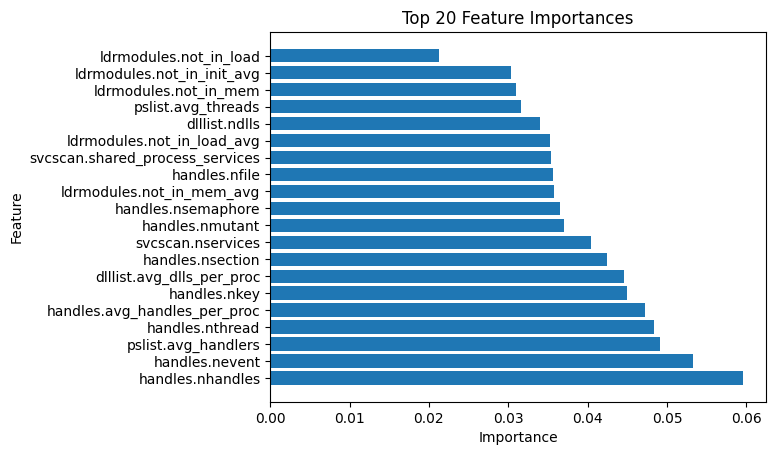

In [ ]:
plt.barh(feature_importance_df["Feature"][:20], feature_importance_df["Importance"][:20])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances")
plt.show()

In [ ]:
mean_dp = np.mean([
    tree.get_depth() for tree in model_rnd_forest.estimators_
], axis=0)
print("średnia głębokość drzew", mean_dp)
print("liczba estymatorów(drzew)",len(model_rnd_forest.estimators_))

średnia głębokość drzew 37.84
liczba estymatorów(drzew) 100


In [ ]:
models_dataframe

,Model,Accuracy,Precision on Benign vs Malware,Recal on Benign vs Malware,F1 on Benign vs Malware
0,Decision tree,0.840413,1.0,0.999306,0.999653
1,Bagging,0.869231,1.0,0.999769,0.999884
2,Random forest,0.871183,1.0,1.000000,1.000000


# XGBOOST

Basic XGB

In [ ]:
xgb_model = xgb.XGBClassifier( )
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy for:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) :  0.8261768082663605


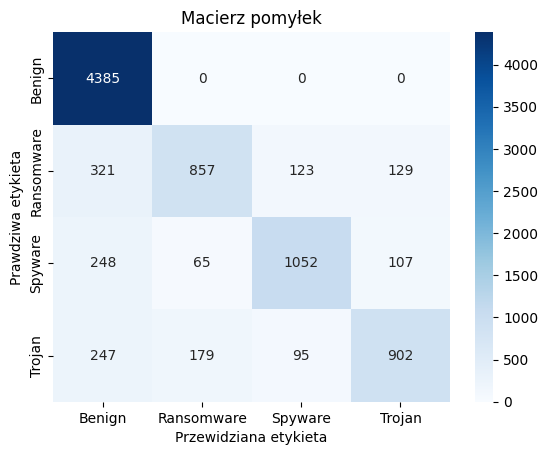

precision:  1.0
recall:  0.8113294797687861
f1:  0.8958386520296144


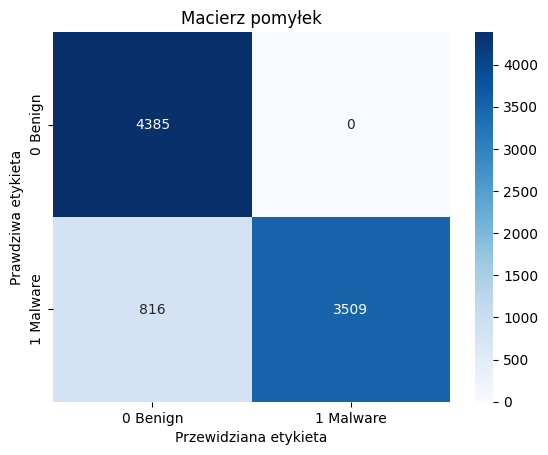

In [ ]:
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, preds_xgb = make_pred(xgb_model, X_test, y_test, 1)

In [ ]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=class_weights_dict, objective='multi:softmax', num_class=4,learning_rate=0.4)
xgb_model.fit(X_train, np.argmax(y_train, axis=1))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

Accuracy for:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...) :  0.8761194029850746


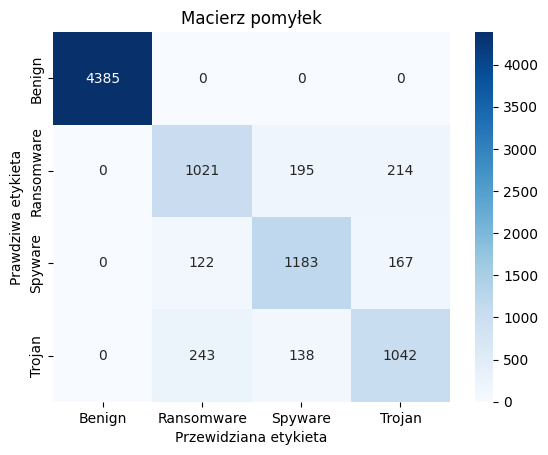

precision:  1.0
recall:  1.0
f1:  1.0


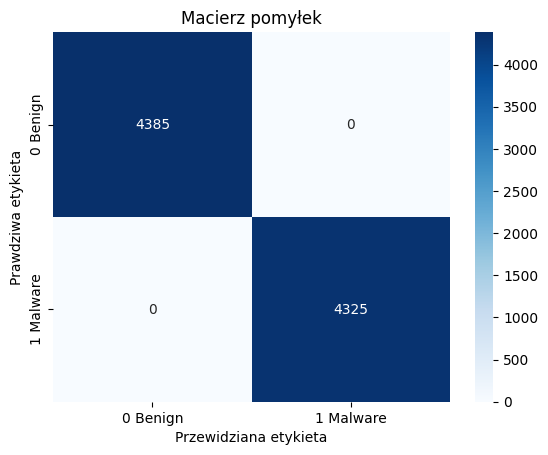

In [ ]:
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, preds_xgb = make_pred(xgb_model, X_test, np.argmax(y_test, axis=1))


In [ ]:
models_dataframe.loc[len(models_dataframe.index)] = ['XGB',accuracy_xgb, precision_xgb, recall_xgb, f1_xgb]

In [ ]:
importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

print(feature_importance_df)

                                   Feature  Importance
43                       svcscan.nservices    0.741948
47         svcscan.shared_process_services    0.050953
42                        modules.nmodules    0.031773
20                   ldrmodules.not_in_mem    0.025825
8                            handles.nfile    0.014900
46                svcscan.process_services    0.013966
5                dlllist.avg_dlls_per_proc    0.012706
23               ldrmodules.not_in_mem_avg    0.011871
18                  ldrmodules.not_in_load    0.006733
24                     malfind.ninjections    0.005905
16                        handles.nsection    0.004718
14                      handles.nsemaphore    0.004419
17                         handles.nmutant    0.003898
25                    malfind.commitCharge    0.003849
27                malfind.uniqueInjections    0.003517
39  psxview.not_in_csrss_handles_false_avg    0.003059
41       psxview.not_in_deskthrd_false_avg    0.003010
13        

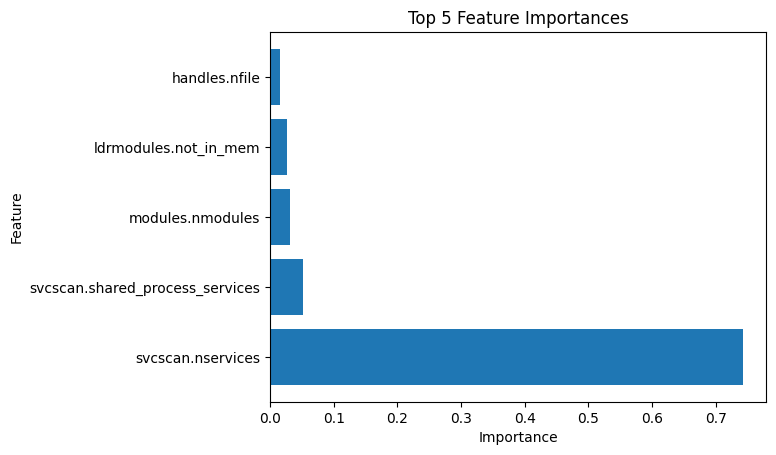

In [ ]:
plt.barh(feature_importance_df["Feature"][:5], feature_importance_df["Importance"][:5])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 5 Feature Importances")
plt.show()

In [ ]:
models_dataframe

,Model,Accuracy,Precision on Benign vs Malware,Recal on Benign vs Malware,F1 on Benign vs Malware
0,Decision tree,0.840413,1.0,0.999306,0.999653
1,Bagging,0.869231,1.0,0.999769,0.999884
2,Random forest,0.871183,1.0,1.000000,1.000000
3,XGB,0.876119,1.0,1.000000,1.000000


# Deep learning

In [ ]:
def build_model(n, no_layers, dropout):
  #imput layer
  inputs = Input(shape=(X_train.shape[1],))
  x = Dense(n, activation='relu')(inputs)

  for _ in range(no_layers):
    x = Dense(n/2, activation='relu')(x)
    x = Dropout(dropout)(x)
    n=n/2
  #output layer
  outputs = Dense(y_train.shape[1], activation='softmax')(x)

  #model compile
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3)

In [ ]:
his_list=[]
neurons_list=[512,256,128]
layers_list=[2,4,6]
dropouts_list=[0.2,0.5,0.7]



for n in neurons_list:
    for l in layers_list:
        for d in dropouts_list:
            print(n,l,d)
            model=build_model(n, l, d)
            his=model.fit(X_train_scal, y_train_scal, epochs=5, validation_data=(X_val_scal, y_val_scal), callbacks=[callback])
            his_list.append(his)

512 2 0.2
Epoch 1/5
1311/1311 [==============================] - 6s 4ms/step - loss: 0.2275 - accuracy: 0.7313 - val_loss: 0.2146 - val_accuracy: 0.7592
Epoch 2/5
1311/1311 [==============================] - 6s 5ms/step - loss: 0.2136 - accuracy: 0.7552 - val_loss: 0.2099 - val_accuracy: 0.7586
Epoch 3/5
1311/1311 [==============================] - 6s 4ms/step - loss: 0.2096 - accuracy: 0.7632 - val_loss: 0.2062 - val_accuracy: 0.7781
Epoch 4/5
1311/1311 [==============================] - 5s 4ms/step - loss: 0.2078 - accuracy: 0.7673 - val_loss: 0.2025 - val_accuracy: 0.7878
Epoch 5/5
1311/1311 [==============================] - 7s 6ms/step - loss: 0.2056 - accuracy: 0.7713 - val_loss: 0.2054 - val_accuracy: 0.7700
512 2 0.5
Epoch 1/5
1311/1311 [==============================] - 7s 4ms/step - loss: 0.2388 - accuracy: 0.7192 - val_loss: 0.2258 - val_accuracy: 0.7388
Epoch 2/5
1311/1311 [==============================] - 7s 5ms/step - loss: 0.2194 - accuracy: 0.7449 - val_loss: 0.2231 - 

In [ ]:
for x in his_list:
  print(x.history['val_accuracy'])

[0.7591516971588135, 0.7586113810539246, 0.7780629396438599, 0.7877887487411499, 0.7699581384658813]
[0.7387545704841614, 0.7445630431175232, 0.7503714561462402, 0.7794137597084045, 0.767121434211731]
[0.726192057132721, 0.746319055557251, 0.7675266861915588, 0.7714440226554871, 0.761718213558197]
[0.7494258880615234, 0.7611778974533081, 0.7663109302520752, 0.7679319381713867, 0.7611778974533081]
[0.7229501605033875, 0.735242486000061, 0.7413210868835449, 0.7402404546737671, 0.7502363920211792]
[0.6682426333427429, 0.6714845299720764, 0.6714845299720764, 0.6712144017219543, 0.6656760573387146]
[0.7126840353012085, 0.7332162857055664, 0.740780770778656, 0.7444279193878174, 0.7465892434120178]
[0.6714845299720764, 0.6710792779922485, 0.6714845299720764, 0.6710792779922485, 0.6714845299720764]
[0.5034445524215698, 0.6710792779922485, 0.668512761592865, 0.668512761592865, 0.668512761592865]
[0.7499662041664124, 0.767121434211731, 0.7691476345062256, 0.7787383198738098, 0.7822504639625549]


In [ ]:
# 256 ,2 ,0.2
his_list[9].history['val_accuracy']

[0.7499662041664124,
 0.767121434211731,
 0.7691476345062256,
 0.7787383198738098,
 0.7822504639625549]

In [ ]:
# 256 ,4 ,0.2
his_list[12].history['val_accuracy']

[0.7341618537902832,
 0.7610428333282471,
 0.7661758661270142,
 0.7702282667160034,
 0.7757665514945984]

In [ ]:
#128 2 0.2
his_list[18].history['val_accuracy']

[0.7395650148391724,
 0.7559097409248352,
 0.7714440226554871,
 0.7673916220664978,
 0.7787383198738098]

In [ ]:
def his_comp(history, t):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2,1)

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('accuracy')

    plt.subplot(2, 2,2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('loss')

    plt.suptitle(f'accuracy and loss: {t}')

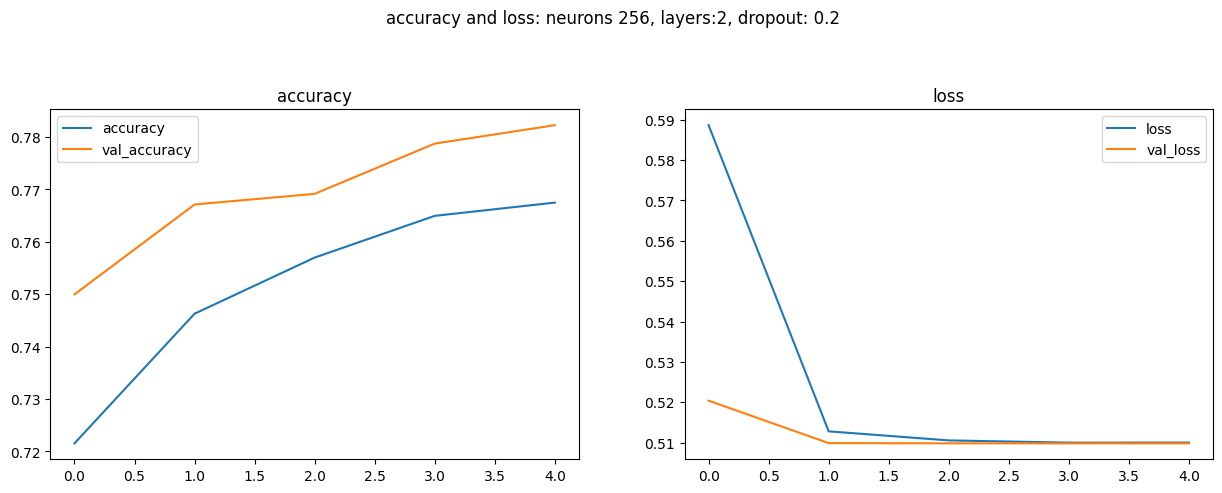

In [ ]:
his_comp(his_list[9],'neurons 256, layers:2, dropout: 0.2')

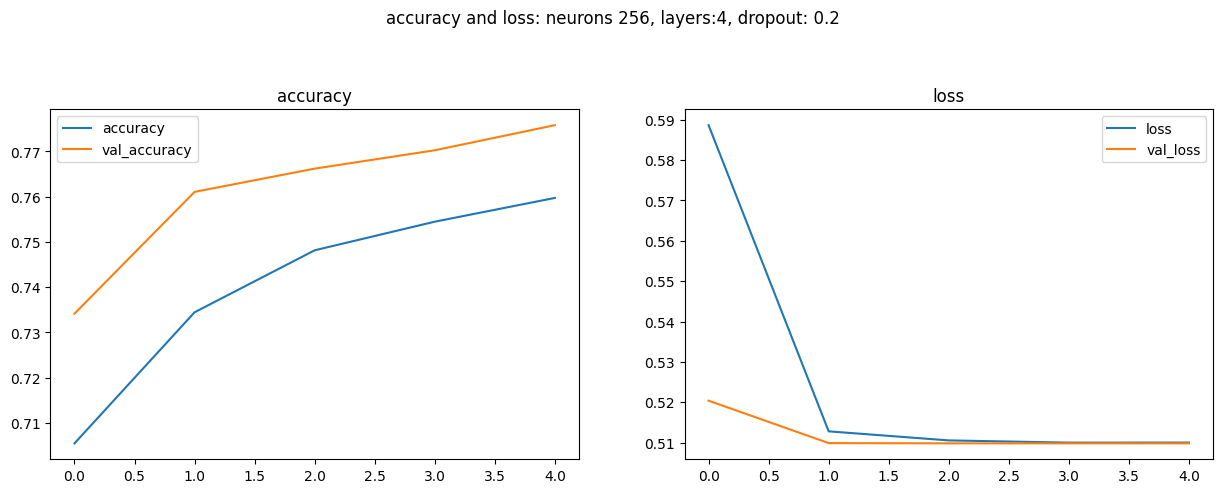

In [ ]:
his_comp(his_list[12],'neurons 256, layers:4, dropout: 0.2')

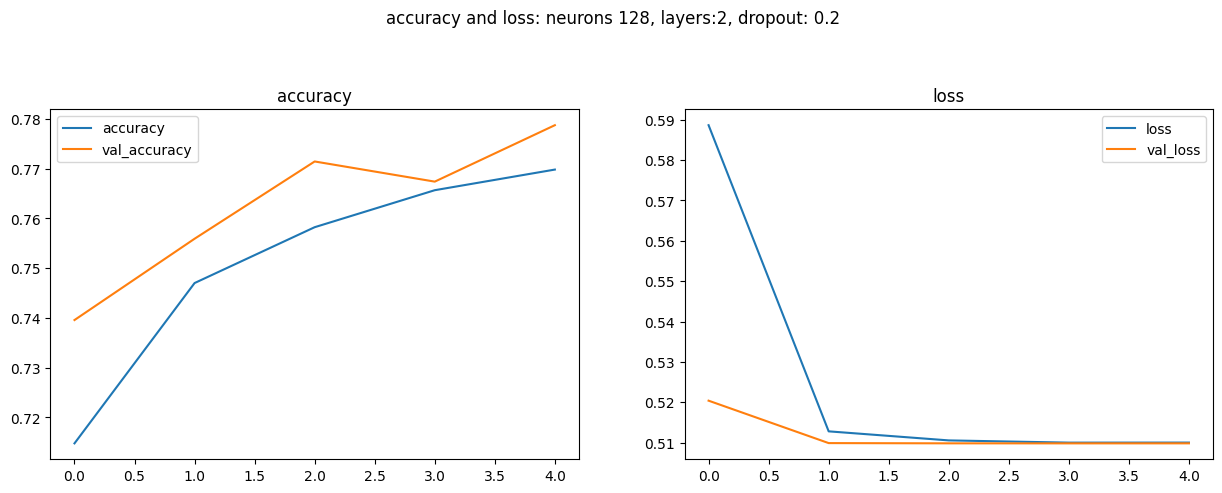

In [ ]:
his_comp(his_list[18],'neurons 128, layers:2, dropout: 0.2')

/////////////////////////////////////////////

In [ ]:
model1=build_model(256, 2, 0.2,)
his1=model1.fit(X_train_scal, y_train_scal, epochs=10, validation_data=(X_val_scal, y_val_scal), callbacks=[callback])

Epoch 1/10
1311/1311 [==============================] - 10s 5ms/step - loss: 0.2308 - accuracy: 0.7223 - val_loss: 0.2203 - val_accuracy: 0.7448
Epoch 2/10
1311/1311 [==============================] - 6s 5ms/step - loss: 0.2166 - accuracy: 0.7523 - val_loss: 0.2121 - val_accuracy: 0.7566
Epoch 3/10
1311/1311 [==============================] - 6s 4ms/step - loss: 0.2108 - accuracy: 0.7609 - val_loss: 0.2164 - val_accuracy: 0.7627
Epoch 4/10
1311/1311 [==============================] - 8s 6ms/step - loss: 0.2091 - accuracy: 0.7676 - val_loss: 0.2102 - val_accuracy: 0.7785
Epoch 5/10
1311/1311 [==============================] - 6s 4ms/step - loss: 0.2082 - accuracy: 0.7729 - val_loss: 0.2139 - val_accuracy: 0.7633
Epoch 6/10
1311/1311 [==============================] - 7s 5ms/step - loss: 0.2062 - accuracy: 0.7732 - val_loss: 0.2066 - val_accuracy: 0.7898
Epoch 7/10
1311/1311 [==============================] - 6s 4ms/step - loss: 0.2048 - accuracy: 0.7794 - val_loss: 0.2034 - val_accuracy

273/273 [==============================] - 1s 2ms/step
Accuracy for:  <keras.src.engine.functional.Functional object at 0x7d07d40eac20> :  0.7827784156142366


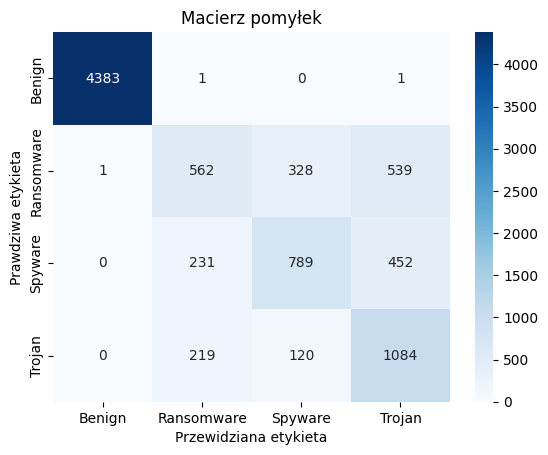

precision:  0.9995376791493297
recall:  0.9997687861271676
f1:  0.999653219281008


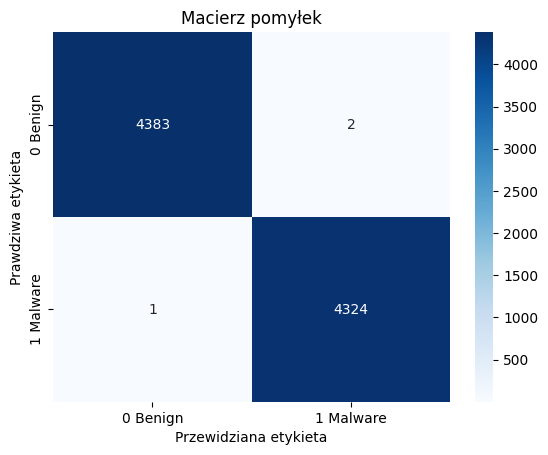

In [ ]:
accuracy_nn, precision_nn, recall_nn, f1_nn, preds_nn = make_pred(model1, X_test_scal, y_test_scal,1)

In [ ]:
inputs = Input(shape=(X_train.shape[1],))
x = Dense(64, activation='relu')(inputs)

x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(y_train.shape[1], activation='softmax')(x)
model2 = Model(inputs=inputs, outputs=outputs)
model2.compile(loss='categorical_crossentropy',metrics=['accuracy'])
his2=model2.fit(X_train_scal, y_train_scal, epochs=5, validation_data=(X_val_scal, y_val_scal), callbacks=[callback])

Epoch 1/5
1311/1311 [==============================] - 11s 6ms/step - loss: 0.5657 - accuracy: 0.6985 - val_loss: 0.5213 - val_accuracy: 0.7285
Epoch 2/5
1311/1311 [==============================] - 5s 4ms/step - loss: 0.5221 - accuracy: 0.7178 - val_loss: 0.5183 - val_accuracy: 0.7342
Epoch 3/5
1311/1311 [==============================] - 8s 6ms/step - loss: 0.5142 - accuracy: 0.7284 - val_loss: 0.5067 - val_accuracy: 0.7421
Epoch 4/5
1311/1311 [==============================] - 8s 6ms/step - loss: 0.5076 - accuracy: 0.7353 - val_loss: 0.5044 - val_accuracy: 0.7548
Epoch 5/5
1311/1311 [==============================] - 9s 7ms/step - loss: 0.5034 - accuracy: 0.7440 - val_loss: 0.5051 - val_accuracy: 0.7589


273/273 [==============================] - 0s 2ms/step
Accuracy for:  <keras.src.engine.functional.Functional object at 0x7b4d66725180> :  0.7562571756601607


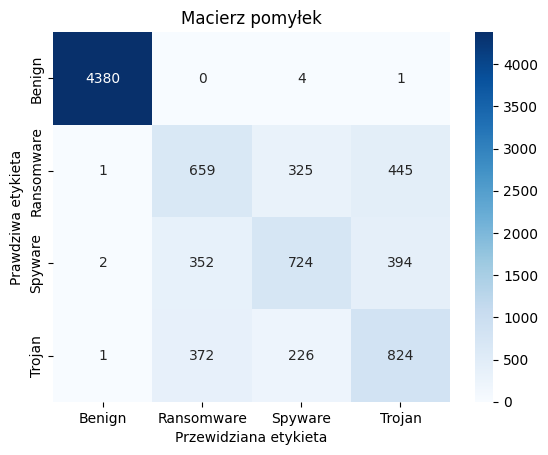

precision:  0.9988441978733241
recall:  0.9990751445086705
f1:  0.9989596578430239


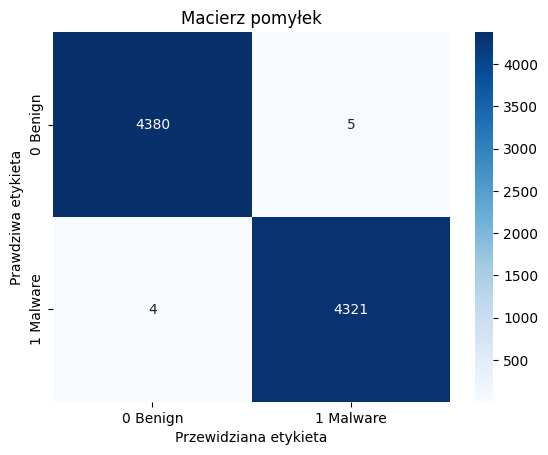

In [ ]:
accuracy_nn, precision_nn, recall_nn, f1_nn, preds_nn = make_pred(model2, X_test_scal, y_test_scal,1)

In [ ]:
inputs = Input(shape=(X_train_scal.shape[1],))
x = Dense(512, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.1)(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(x)


outputs = Dense(y_train.shape[1], activation='softmax')(x)

model3 = Model(inputs=inputs, outputs=outputs)
model3.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

his3=model3.fit(X_train_scal, y_train_scal,class_weight=class_weights_dict, epochs=40,batch_size=32, validation_data=(X_val_scal, y_val_scal), callbacks=[callback])

Epoch 1/40
1311/1311 [==============================] - 24s 15ms/step - loss: 0.9307 - accuracy: 0.7180 - val_loss: 0.5804 - val_accuracy: 0.7401
Epoch 2/40
1311/1311 [==============================] - 14s 11ms/step - loss: 0.8054 - accuracy: 0.7363 - val_loss: 0.5304 - val_accuracy: 0.7544
Epoch 3/40
1311/1311 [==============================] - 12s 9ms/step - loss: 0.7763 - accuracy: 0.7470 - val_loss: 0.5176 - val_accuracy: 0.7571
Epoch 4/40
1311/1311 [==============================] - 7s 5ms/step - loss: 0.7574 - accuracy: 0.7537 - val_loss: 0.5081 - val_accuracy: 0.7585
Epoch 5/40
1311/1311 [==============================] - 9s 7ms/step - loss: 0.7546 - accuracy: 0.7551 - val_loss: 0.5031 - val_accuracy: 0.7627
Epoch 6/40
1311/1311 [==============================] - 7s 5ms/step - loss: 0.7425 - accuracy: 0.7589 - val_loss: 0.5002 - val_accuracy: 0.7693
Epoch 7/40
1311/1311 [==============================] - 8s 6ms/step - loss: 0.7376 - accuracy: 0.7609 - val_loss: 0.4979 - val_accu

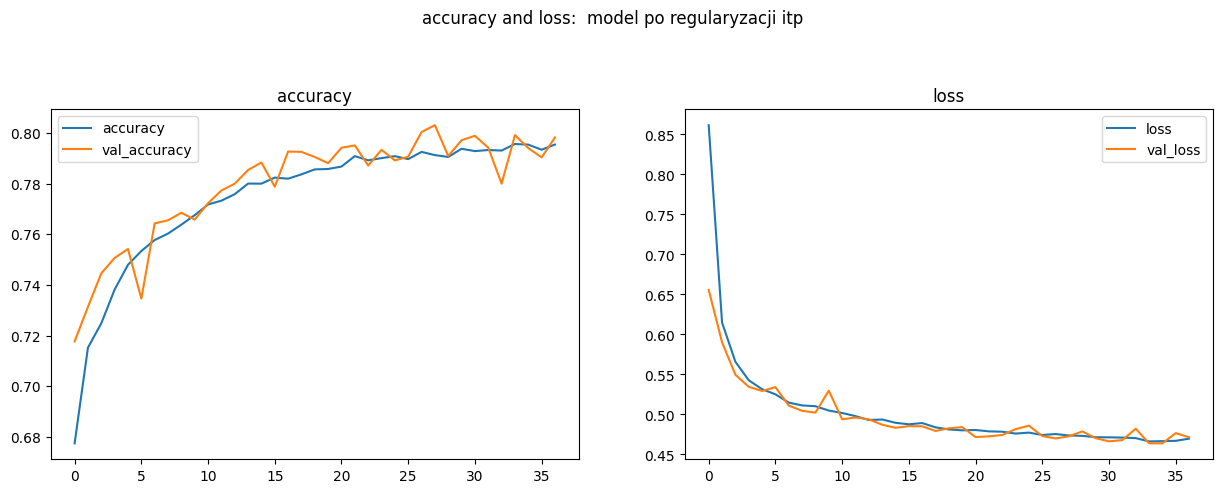

In [ ]:
his_comp(his3,' model po regularyzacji itp')

273/273 [==============================] - 1s 2ms/step
Accuracy for:  <keras.src.engine.functional.Functional object at 0x7eead8de18d0> :  0.8002296211251435


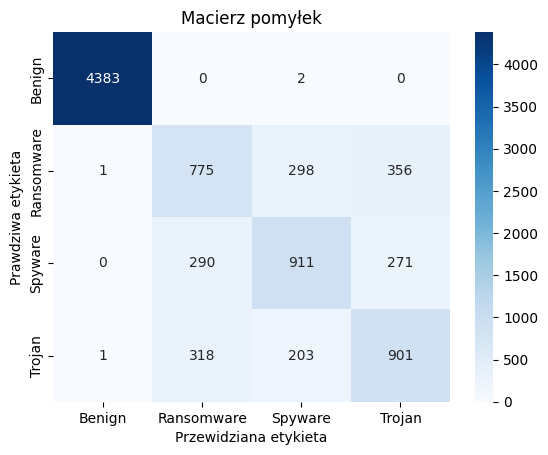

precision:  0.9995375722543353
recall:  0.9995375722543353
f1:  0.9995375722543353


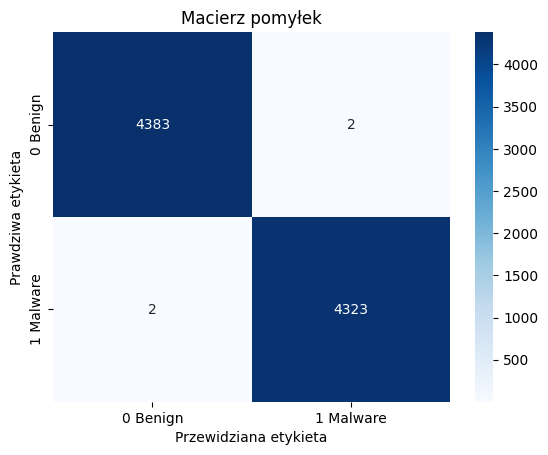

In [ ]:
accuracy_nn, precision_nn, recall_nn, f1_nn, preds_nn = make_pred(model3, X_test_scal, y_test_scal,1)

Epoch 1/10
1311/1311 [==============================] - 12s 6ms/step - loss: 0.2334 - accuracy: 0.7180 - val_loss: 0.2165 - val_accuracy: 0.7465
Epoch 2/10
1311/1311 [==============================] - 8s 6ms/step - loss: 0.2156 - accuracy: 0.7489 - val_loss: 0.2115 - val_accuracy: 0.7610
Epoch 3/10
1311/1311 [==============================] - 6s 4ms/step - loss: 0.2101 - accuracy: 0.7592 - val_loss: 0.2115 - val_accuracy: 0.7420
Epoch 4/10
1311/1311 [==============================] - 7s 6ms/step - loss: 0.2066 - accuracy: 0.7674 - val_loss: 0.2026 - val_accuracy: 0.7778
Epoch 5/10
1311/1311 [==============================] - 6s 4ms/step - loss: 0.2028 - accuracy: 0.7730 - val_loss: 0.1997 - val_accuracy: 0.7914
Epoch 6/10
1311/1311 [==============================] - 6s 5ms/step - loss: 0.1997 - accuracy: 0.7808 - val_loss: 0.1978 - val_accuracy: 0.7825
Epoch 7/10
1311/1311 [==============================] - 7s 5ms/step - loss: 0.1972 - accuracy: 0.7843 - val_loss: 0.2012 - val_accuracy

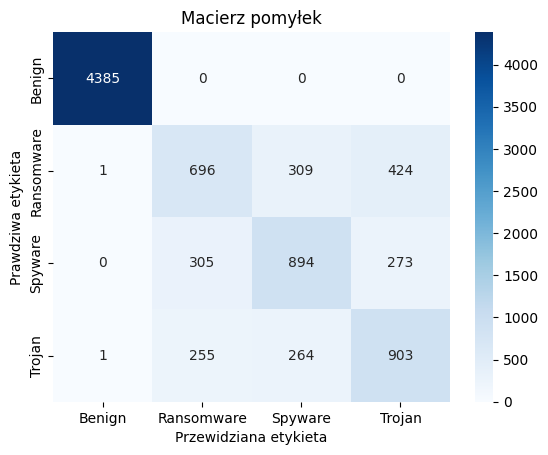

precision:  1.0
recall:  0.9995375722543353
f1:  0.9997687326549491


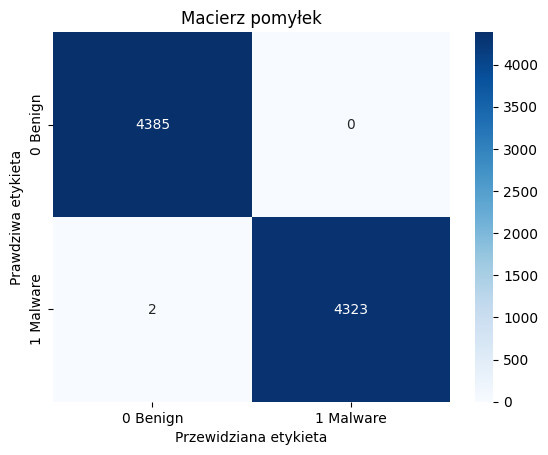

In [ ]:
inputs = Input(shape=(X_train.shape[1],))
x = Dense(256, activation='relu')(inputs)

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(y_train.shape[1], activation='softmax')(x)
model_o = Model(inputs=inputs, outputs=outputs)
model_o.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

his_o=model_o.fit(X_train_scal, y_train_scal, epochs=10, validation_data=(X_val_scal, y_val_scal), callbacks=[callback])
accuracy_nn, precision_nn, recall_nn, f1_nn, preds_nn = make_pred(model_o, X_test_scal, y_test_scal,1)

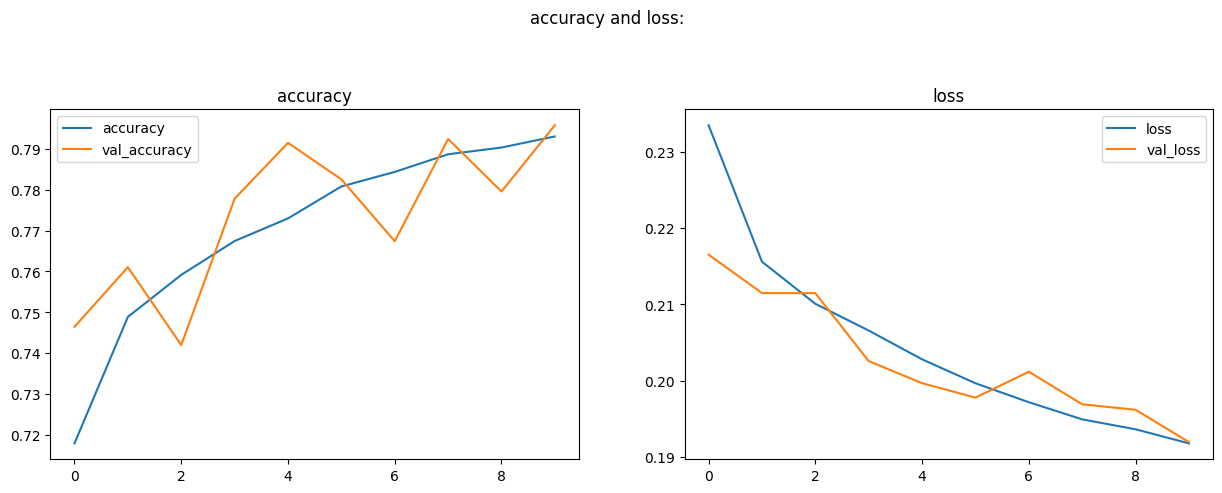

In [ ]:
his_comp(his_o,' ')

Epoch 1/40
1311/1311 [==============================] - 8s 5ms/step - loss: 0.2351 - accuracy: 0.7184 - val_loss: 0.2198 - val_accuracy: 0.7324
Epoch 2/40
1311/1311 [==============================] - 7s 5ms/step - loss: 0.2163 - accuracy: 0.7472 - val_loss: 0.2128 - val_accuracy: 0.7527
Epoch 3/40
1311/1311 [==============================] - 6s 4ms/step - loss: 0.2102 - accuracy: 0.7599 - val_loss: 0.2107 - val_accuracy: 0.7660
Epoch 4/40
1311/1311 [==============================] - 8s 6ms/step - loss: 0.2067 - accuracy: 0.7671 - val_loss: 0.2028 - val_accuracy: 0.7725
Epoch 5/40
1311/1311 [==============================] - 6s 4ms/step - loss: 0.2032 - accuracy: 0.7730 - val_loss: 0.2003 - val_accuracy: 0.7794
Epoch 6/40
1311/1311 [==============================] - 7s 6ms/step - loss: 0.2000 - accuracy: 0.7793 - val_loss: 0.1997 - val_accuracy: 0.7835
Epoch 7/40
1311/1311 [==============================] - 6s 4ms/step - loss: 0.1985 - accuracy: 0.7828 - val_loss: 0.1976 - val_accuracy:

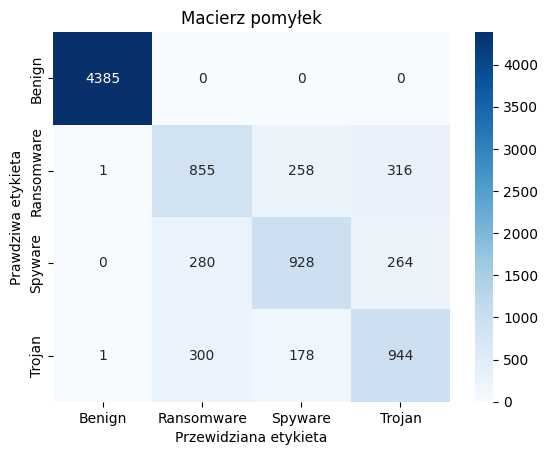

precision:  1.0
recall:  0.9995375722543353
f1:  0.9997687326549491


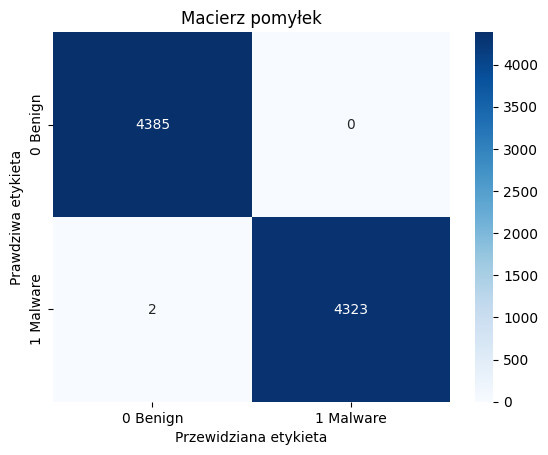

In [ ]:
inputs = Input(shape=(X_train.shape[1],))
x = Dense(256, activation='relu')(inputs)

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(y_train.shape[1], activation='softmax')(x)
model_o1 = Model(inputs=inputs, outputs=outputs)
model_o1.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

his_o1=model_o1.fit(X_train_scal, y_train_scal, epochs=40,batch_size=32, validation_data=(X_val_scal, y_val_scal), callbacks=[callback])
accuracy_nn1, precision_nn1, recall_nn1, f1_nn1, preds_nn1 = make_pred(model_o1, X_test_scal, y_test_scal,1)

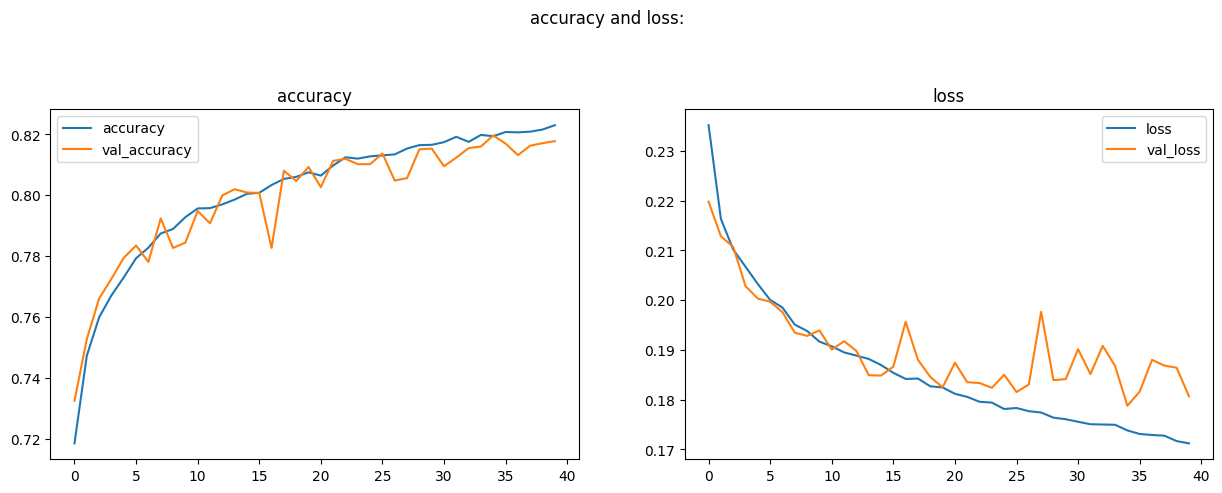

In [ ]:
his_comp(his_o1,' ')

In [ ]:
models_dataframe.loc[len(models_dataframe.index)] = ['ann',accuracy_nn1, precision_nn1, recall_nn1, f1_nn1]

# Results

In [ ]:
models_dataframe

,Model,Accuracy,Precision on Benign vs Malware,Recal on Benign vs Malware,F1 on Benign vs Malware
0,Decision tree,0.840413,1.0,0.999306,0.999653
1,Bagging,0.869231,1.0,0.999769,0.999884
2,Random forest,0.871183,1.0,1.000000,1.000000
3,XGB,0.876119,1.0,1.000000,1.000000
4,ann,0.816533,1.0,0.999538,0.999769
